## Accessing US Census data with the Planetary Computer STAC API

The [US Census](https://planetarycomputer.microsoft.com/dataset/us-census) collection provides information on population, demographics, and administrative boundaries at various levels of cartographic aggregation for the United States. It consists of many tabular datasets, one for each level of cartographic aggregation, each stored in [Apache Parquet](https://parquet.apache.org/) format. In this notebook, we'll use [geopandas](https://geopandas.org/) and dask-geopandas to read the files, which will preserve the `geometry` column with administrative boundaries.

In [1]:
import geopandas
import dask_geopandas
import contextily as ctx
import seaborn as sns
import planetary_computer
import pystac_client
import fsspec

Start by creating a client for the Planetary Computer's STAC Catalog to get all the items for the `us-census` collection. Each `item` represents a single table, aggregating the census data a some level (Congressional district, state, etc.).

In [2]:
# ignore_conformance until https://github.com/stac-utils/pystac-client/issues/93 is fixed
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)
search = catalog.search(collections=["us-census"])
items = search.get_all_items()
items = {x.id: x for x in items}
list(items)

['2020-cb_2020_us_vtd_500k',
 '2020-cb_2020_us_unsd_500k',
 '2020-cb_2020_us_ttract_500k',
 '2020-cb_2020_us_tract_500k',
 '2020-cb_2020_us_tbg_500k',
 '2020-cb_2020_us_state_500k',
 '2020-cb_2020_us_sldu_500k',
 '2020-cb_2020_us_sldl_500k',
 '2020-cb_2020_us_scsd_500k',
 '2020-cb_2020_us_region_500k',
 '2020-cb_2020_us_place_500k',
 '2020-cb_2020_us_nectadiv_500k',
 '2020-cb_2020_us_necta_500k',
 '2020-cb_2020_us_nation_5m',
 '2020-cb_2020_us_metdiv_500k',
 '2020-cb_2020_us_elsd_500k',
 '2020-cb_2020_us_division_500k',
 '2020-cb_2020_us_csa_500k',
 '2020-cb_2020_us_cousub_500k',
 '2020-cb_2020_us_county_within_cd116_500k',
 '2020-cb_2020_us_county_500k',
 '2020-cb_2020_us_concity_500k',
 '2020-cb_2020_us_cnecta_500k',
 '2020-cb_2020_us_cd116_500k',
 '2020-cb_2020_us_cbsa_500k',
 '2020-cb_2020_us_bg_500k',
 '2020-cb_2020_us_aitsn_500k',
 '2020-cb_2020_us_aiannh_500k',
 '2020-cb_2020_72_subbarrio_500k',
 '2020-cb_2020_02_anrc_500k']

### Read Congressional districts

The `2020-cb_2020_us_cd116_500k` dataset contains geometries for Congressional Districts for the 166th Congress.

In [3]:
item = items["2020-cb_2020_us_cd116_500k"]
item

<Item id=2020-cb_2020_us_cd116_500k>

Each of the items contains a single asset, `data`, that has all the URL to the Parquet dataset and all the information necessary to load it.

In [4]:
item.assets["data"]

<Asset href=abfs://us-census/2020/cb_2020_us_cd116_500k.parq>

This is an [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) URL, which is used by libraries like pandas, geopandas, and Dask to work with files from remote storage like Azure Blob Storage. Make sure to [sign](https://planetarycomputer.microsoft.com/docs/concepts/sas) the asset prior to using it. If you use an unsigned asset you'll see a `ClientAuthenticationError` error when trying to open the dataset.

In [5]:
signed_asset = planetary_computer.sign(item.assets["data"])

Now we can load the file using geopandas.

In [6]:
protocol, url = signed_asset.href.split("://")
url = url.replace(".parq", ".parquet")  # TODO: remove after re-ingesting
fs = fsspec.filesystem(protocol, **signed_asset.extra_fields["table:storage_options"])
df = geopandas.read_parquet(url, filesystem=fs)
df.head()

,STATEFP,CD116FP,AFFGEOID,GEOID,NAMELSAD,LSAD,CDSESSN,ALAND,AWATER,geometry
__null_dask_index__,,,,,,,,,,
0,06,42,5001600US0642,0642,Congressional District 42,C2,116,2424753563,44105315,"POLYGON ((-117.67629 33.88882, -117.65488 33.8..."
1,39,7,5001600US3907,3907,Congressional District 7,C2,116,10010016396,64562455,"MULTIPOLYGON (((-82.55933 40.78975, -82.55835 ..."
2,48,3,5001600US4803,4803,Congressional District 3,C2,116,1245574011,97890112,"POLYGON ((-96.84410 32.98891, -96.84403 32.992..."
3,28,2,5001600US2802,2802,Congressional District 2,C2,116,40278711117,951654563,"POLYGON ((-91.36371 31.78036, -91.35951 31.799..."
4,42,18,5001600US4218,4218,Congressional District 18,C2,116,757655195,19985421,"POLYGON ((-80.17834 40.33725, -80.17537 40.338..."


We'll select a single district (Maryland's 2nd) and plot it.

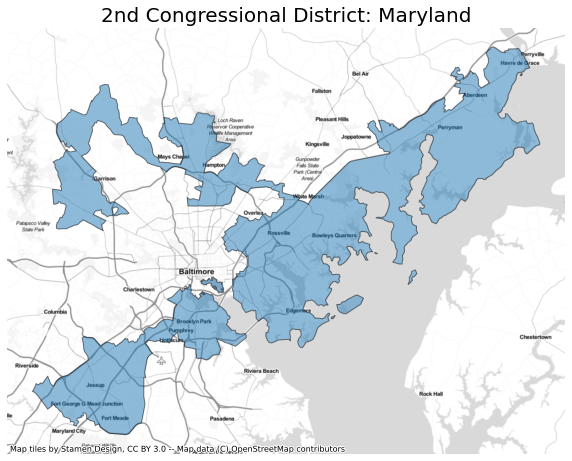

In [7]:
ax = (
    df[df.GEOID == "2402"]
    .to_crs(epsg=3857)
    .plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
)
ax.set_title(
    "2nd Congressional District: Maryland",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

### Read Census Block data

Census blocks are the smallest cartographic unit available from the Census Bureau. There are over 8 million census blocks. We'll read in all the blocks for Rhode Island.

In [8]:
df = dask_geopandas.read_parquet(
    "abfs://us-census/2020/tl_2020_FULL_tabblock20.parquet/STATEFP20=44",
    storage_options=signed_asset.extra_fields["table:storage_options"],
).compute()
df

,TRACTCE20,BLOCKCE20,GEOID20,NAME20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,STUSAB,P0010001,COUNTYFP20
185,30901,2014,440010309012014,Block 2014,0,779099,41.692854,-71.238148,"POLYGON ((-71.24629 41.69611, -71.24629 41.696...",RI,0.0,1
186,30902,2004,440010309022004,Block 2004,250447,2854,41.702324,-71.284569,"POLYGON ((-71.29164 41.70047, -71.29159 41.700...",RI,210.0,1
187,30100,3007,440010301003007,Block 3007,10962,0,41.743996,-71.350485,"POLYGON ((-71.35124 41.74466, -71.35045 41.744...",RI,38.0,1
188,30100,1011,440010301001011,Block 1011,49512,0,41.757984,-71.333816,"POLYGON ((-71.33592 41.75772, -71.33591 41.757...",RI,25.0,1
190,30400,2012,440010304002012,Block 2012,17371,0,41.727262,-71.298160,"POLYGON ((-71.29930 41.72778, -71.29709 41.727...",RI,17.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
25501,51102,2000,440090511022000,Block 2000,216905,0,41.390146,-71.620076,"POLYGON ((-71.62588 41.38747, -71.62587 41.388...",RI,34.0,9
25502,50103,4050,440090501034050,Block 4050,37833,0,41.611817,-71.472306,"POLYGON ((-71.47394 41.61269, -71.47375 41.612...",RI,60.0,9
25503,51302,2005,440090513022005,Block 2005,657609,5279,41.408160,-71.514161,"POLYGON ((-71.52034 41.40835, -71.52013 41.408...",RI,11.0,9
25504,50901,3016,440090509013016,Block 3016,6652,0,41.392900,-71.815744,"POLYGON ((-71.82212 41.39401, -71.82210 41.394...",RI,0.0,9


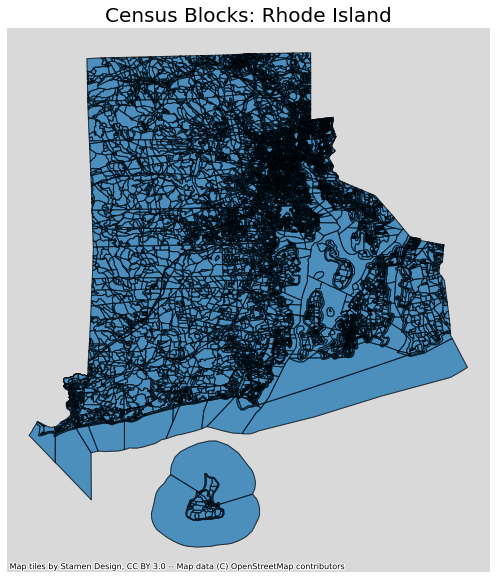

In [9]:
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Census Blocks: Rhode Island",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, zoom=15, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Let's filter out the blocks with 0 reported population and plot the distribution of people per census block.

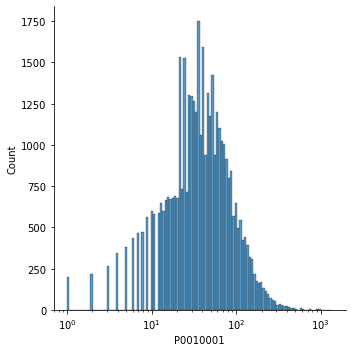

In [10]:
populated = df[df.P0010001 > 0].reset_index(drop=True)

sns.displot(populated.P0010001, log_scale=True);

Or we can plot the relationship between the population and the size of the census block.

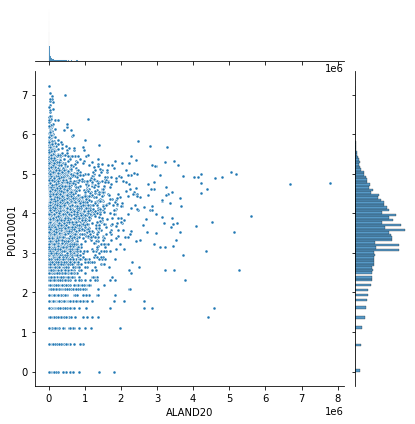

In [11]:
import numpy as np

sns.jointplot(x=populated.ALAND20, y=np.log(populated.P0010001), marker=".");

### Next Steps

Now that you've seen an introduction to working with US Census data from the Planetary Computer, learn more with

* The [US Census data tutorial](https://github.com/microsoft/PlanetaryComputerExamples/tree/main/tutorials/census-data.ipynb), which includes examples for accessing data at each level of cartographic aggregation available
* The [Reading tabular data quickstart](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-tabular-data/), which introduces how to use tabular data with the Planetary Computer